In [ ]:
# Import our data here
import pandas as pd
import numpy as np
import io
import requests
import re
from google.colab import files

# Load libraries
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

df = pd.read_csv('sample.csv')
# Read the data in
#df = pd.read_csv("malicious_phish.csv")
#df = pd.read_csv('sample2.csv')
url_list = df.url

In [ ]:
# Rules for us to implement, or "flags"
# 1.  If url contains "%00" 
def containsPercent00(str):
  if str.find("%00"):
    return 1
  else:
    return 0

# 2.  If url contains "%01"
def containsPercent01(str):
  if str.find("%01"):
    return 1
  else:
    return 0

# 3.  If url contains '-' if more than four, then fradulent
def containsFourDash(str):
  if str.count("-") == 4:
    return 1
  else:
    return 0


# 4.  If (perform get request) url returned != url sent 
def checkIf_URLsent_equals_getURL(str):
  temp = (requests.head("http://"+str).headers['location'])
  if temp != str:
    return 1
  else:
    return 0

# 5.  If url contains more than one instance of "http://"
def containsMoreHttp(str):
  if str.count("http://") > 1:
    return 1
  else:
    return 0


# 6.  If url contains more than one instance of "https://"
def containsMoreHttps(str):
  if str.count("https://") > 1:
    return 1
  else:
    return 0

# 7.  If url contains "http://" AND "https://"
def containsHttpAndHttps(str):
  if "http://" in str and "https://" in str:
    return 1
  else:
    return 0



# 8.  If url is over 54 characters
def over54Chars(str):
  if len(str) > 54:
    return 1
  else:
    return 0


# 9.  If url has more than one instance of a domain extension
def hasMoreExtension(str):
  if ".com" in str and ".net" in str and ".org" in str:
    return 1
  else:
    return 0


# 10. If url does not contain "https://"
def doesNotContainHttps(str):
  if "https://" not in str:
    return 1
  else:
    return 0

# 11. If url contains "index.php"
def overIndexPhp(str):
  if str.find("index.php"):
    return 1
  else:
    return 0
# 12. If url has "@"
def hasAt(str):
  if "@" in str:
    return 1
  else:
    return 0

# 13. If url has "//" after seventh position
def hasTwoSlash(str):
  if str.find("//")!=-1 and str.find("//")>7:
    return 1
  else:
    return 0
  
# 14. If url has multiple subdomains  
def hasMultDom(str):
  dom = re.search("(?<=:\/\/)[^/]*", str)
  if(not dom): return 0
  if(dom.group(0).count(".")>2): return 1
  return 0


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from scipy.sparse import csr_matrix, hstack

#reading from sample file with file upload(in sidebar)
#df = pd.read_csv('malicious_phish.csv')
#making pipeline to extract and adjust features for training
#url_list = df.url
pipe = Pipeline(
    [
     ('count',CountVectorizer()),
     ('tfidf',TfidfTransformer()),
     ('scale',StandardScaler(with_mean=False)),
     ('feature selection', VarianceThreshold())
     ])
pipe.fit(url_list)
Xa = pipe.transform(url_list)

# create a list to represent the 2D Matrix "xb"
# for loop through url list
#     at each url, create a list 
#     then, look at each of the 14 rules we created
#     append the results of these functions to the list we created
#     after appending all of the results, add the current list to "Xb"
Xb = []
for i in range(0,url_list.size):
    new = []
    new.append(containsPercent00(url_list[i]))
    new.append(containsPercent01(url_list[i]))
    new.append(containsFourDash(url_list[i]))
    #new.append(checkIf_URLsent_equals_getURL(url_list[i]))
    new.append(containsMoreHttp(url_list[i]))
    new.append(containsMoreHttps(url_list[i]))
    new.append(over54Chars(url_list[i]))
    new.append(hasMoreExtension(url_list[i]))
    new.append(doesNotContainHttps(url_list[i]))
    new.append(overIndexPhp(url_list[i]))
    new.append(hasAt(url_list[i]))
    new.append(hasTwoSlash(url_list[i]))
    new.append(hasMultDom(url_list[i]))
    Xb.append(new)

#cocatenating the two feature matrices
X = Xb
#generating labels from data
result = df.type
y = []
for i in range (0,result.size):
    if result[i]=="benign": y.append(0)
    else: y.append(1)

In [ ]:
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
#splitting into test and train sets


X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0,test_size=.3)
#using sci kit learn's decision tree function to create a model
#clf=LogisticRegression(random_state=0,max_iter=100000000000).fit(X_train,y_train)
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("accuracy of decision tree:")
print(clf.score(X_test,y_test))
#-------------------------------------------------
print("precision:")
print(precision_score(y_test,clf.predict(X_test)))
print("AUC:")
print(roc_auc_score(y_test,clf.predict(X_test)))
print("Recall:")
print(recall_score(y_test,clf.predict(X_test)))
print("F1:")
print(f1_score(y_test,clf.predict(X_test)))

accuracy of decision tree:
0.7868852459016393
precision:
1.0
AUC:
0.59375
Recall:
0.1875
F1:
0.3157894736842105


|--- feature_5 <= 0.50
|   |--- class: 0
|--- feature_5 >  0.50
|   |--- feature_11 <= 0.50
|   |   |--- feature_7 <= 0.50
|   |   |   |--- class: 0
|   |   |--- feature_7 >  0.50
|   |   |   |--- feature_2 <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- feature_2 >  0.50
|   |   |   |   |--- class: 0
|   |--- feature_11 >  0.50
|   |   |--- class: 1



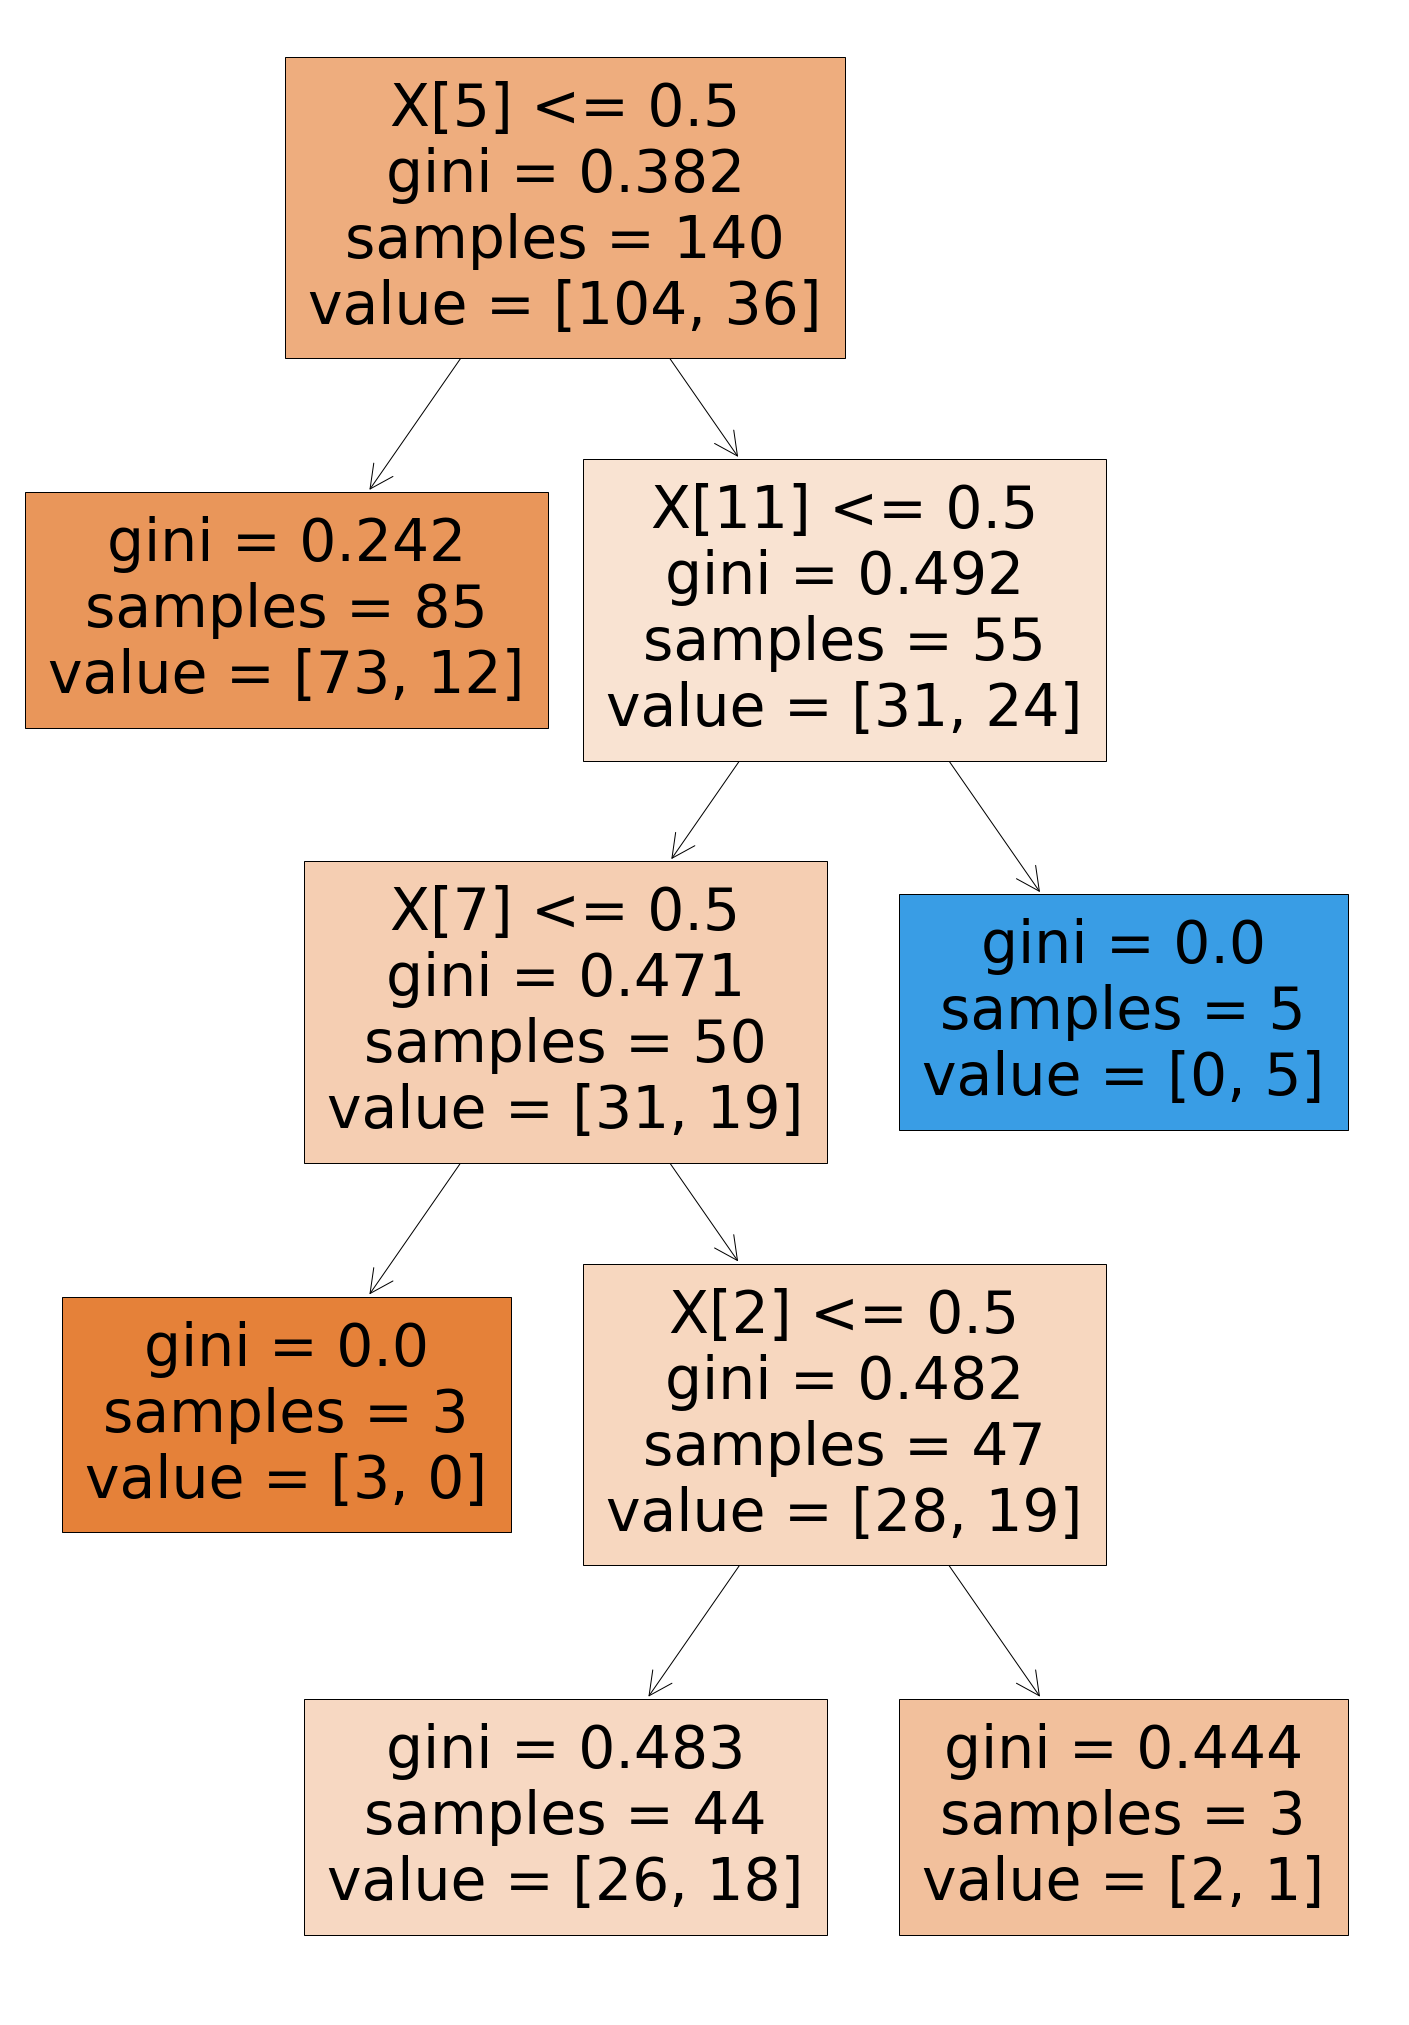

In [ ]:
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree


#Text Representation
text_representation = tree.export_text(clf)
print(text_representation)

import graphviz
# DOT data
dot_data = tree.export_graphviz(clf, out_file=None,
                                max_depth = 2, 
                                feature_names=None,  
                                class_names=None,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph
